In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone "https://github.com/maria-natale/ProgettoFVAB"

Cloning into 'ProgettoFVAB'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 266 (delta 102), reused 146 (delta 36), pack-reused 0
Receiving objects: 100% (266/266), 1.42 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [28]:
with tf.device('/device:GPU:0'):
  !python "/content/ProgettoFVAB/Code/create_dataset_2Lan.py"

(117, 2)
(40, 2)
(39, 2)
100% 93/93 [00:01<00:00, 65.62it/s]
100% 98/98 [00:42<00:00,  2.30it/s]
106it [00:16,  6.58it/s]
100% 93/93 [00:00<00:00, 101.92it/s]
100% 98/98 [00:00<00:00, 112.66it/s]
39it [00:05,  6.76it/s]
100% 93/93 [00:00<00:00, 101.67it/s]
100% 98/98 [00:01<00:00, 96.29it/s] 
36it [00:05,  6.71it/s]
(144, 2)
(46, 2)
(50, 2)
100% 93/93 [00:01<00:00, 58.43it/s]
100% 146/146 [01:02<00:00,  2.34it/s]
135it [00:20,  6.47it/s]
100% 93/93 [00:00<00:00, 108.35it/s]
100% 146/146 [00:01<00:00, 106.40it/s]
43it [00:06,  6.58it/s]
100% 93/93 [00:00<00:00, 95.95it/s]
100% 146/146 [00:01<00:00, 97.37it/s]
49it [00:07,  6.59it/s]
(187, 2)
(56, 2)
(62, 2)
100% 93/93 [00:01<00:00, 59.05it/s]
100% 227/227 [01:40<00:00,  2.26it/s]
180it [00:28,  6.38it/s]
100% 93/93 [00:00<00:00, 127.08it/s]
100% 227/227 [00:02<00:00, 97.74it/s]
56it [00:08,  6.60it/s]
100% 93/93 [00:00<00:00, 97.62it/s]
100% 227/227 [00:02<00:00, 103.25it/s]
59it [00:08,  6.56it/s]
(107, 2)
(36, 2)
(37, 2)
100% 93/93 [0

In [27]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = '4_7'
path_drive = '/content/drive/MyDrive/Casillo&Natale/dataset'
dataset_dir = 'dataset_4_7/datasetCSV'
LANGUAGES = {
    4:'Spagnolo',
  7: 'Giapponese'}
LANGUAGES_N = {
    4:0,
    7:1
}


# Caricamento dei dati

In [ ]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive+'/'+dataset_dir+'/features/'
    os.chdir(os.path.join(filepath, group))
    filenames = []
    filenames = [group+'/feature'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    os.chdir(os.path.join(path_drive, dataset_dir, 'csv'))
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    print(testX.shape, testy.shape)
    validationX, validationy = load_dataset_group('validation', prefix)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)
    validationy['language'] = validationy['language'].map(LANGUAGES_N)
    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    validationy = to_categorical(validationy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, validationX.shape, validationy.shape)
    return trainX, trainy, testX, testy, validationX, validationy

    
  

# Definizione del modello

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

verbose, epochs, batch_size = 0, 500, 16
def create_model():
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.5))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
    model.add(Dropout(0.5))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 50)))
    model.add(Dropout(0.5))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
    )

    return model
    



# Sperimentazione Spagnolo Giapponese con Early Stopping

In [ ]:
def run_experiment(model, trainX, trainy, validationX, validationy, testX, testy):
  tf.random.set_seed(42)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 100)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy), callbacks = [es]) 
  #model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions


In [ ]:
# run the experiment
with tf.device('/device:GPU:0'):
  trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
  model = create_model()
  history, predictions = run_experiment(model, trainX, trainy, validationX, validationy, testX, testy)

(148, 350, 66) (148, 1)
(55, 350, 66) (55, 1)
(148, 350, 66) (148, 2) (55, 350, 66) (55, 2) (50, 350, 66) (50, 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 00130: early stopping
2/2 [==============================] - 0s 34ms/step - loss: 0.5235 - accuracy: 0.8727


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1]


In [ ]:
from sklearn.metrics import classification_report
testy = np.argmax(testy, axis=1)
target_names = list(LANGUAGES.values())
print(classification_report(testy, predictions, target_names=target_names))

              precision    recall  f1-score   support

    Spagnolo       0.90      0.93      0.92        41
  Giapponese       0.77      0.71      0.74        14

    accuracy                           0.87        55
   macro avg       0.84      0.82      0.83        55
weighted avg       0.87      0.87      0.87        55



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])



[[[10  4]
  [ 2 39]]

 [[39  2]
  [ 4 10]]]


Text(132.0, 0.5, 'predetti')

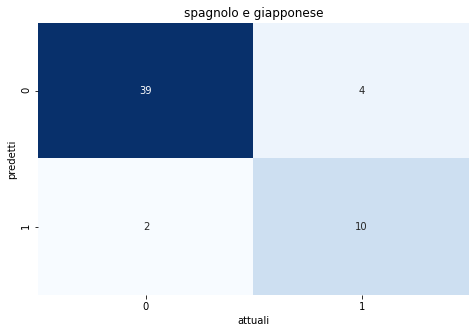

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

valori=pd.crosstab(predictions,testy)
fig=plt.figure(figsize=(17,5))
ax1=plt.subplot(121)
ax1.set_title("spagnolo e giapponese")
sns.heatmap(valori,annot=True,cmap="Blues",cbar=False)
plt.xlabel("attuali") 
plt.ylabel("predetti")


CONFUSION MATRIX

39 4 2 10
10 2 4 39


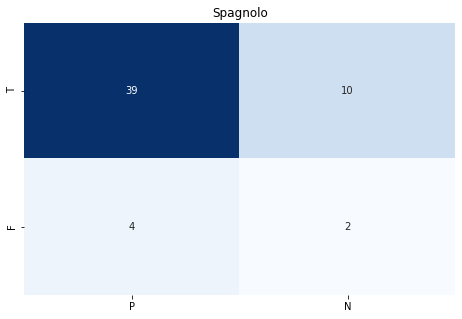

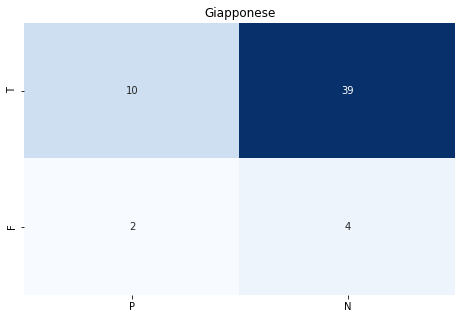

In [ ]:
for j in (list(LANGUAGES_N.keys())):
  i = LANGUAGES_N[j]
  TP= valori.iloc[i,i]
  FP= valori.iloc[i,:].sum()-TP
  FN= valori.iloc[:,i].sum()-TP
  TN= valori.sum().sum() - TP - FP - FN
  print(TP,FP,FN,TN)
  #b=[[TP,FP],[FN,TN]]
  b=[[TP,TN],[FP,FN]]
  fig=plt.figure(figsize=(17,5))
  ax1=plt.subplot(121)
  sns.heatmap(b,annot=True,cmap="Blues",cbar=False,fmt = "g")
  #plt.xlabel("POSITIVI") 
  #plt.ylabel("NEGATIVI")
  tick_marks = [0.5,1.5]
  plt.title(LANGUAGES[j])
  plt.xticks(tick_marks, ["P","N",])
  plt.yticks(tick_marks, ["T","F"])

ROC CURVE

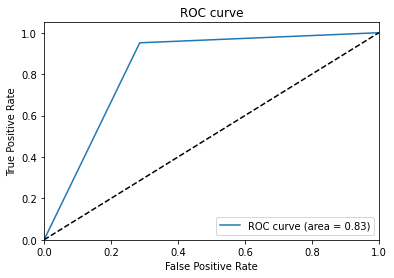

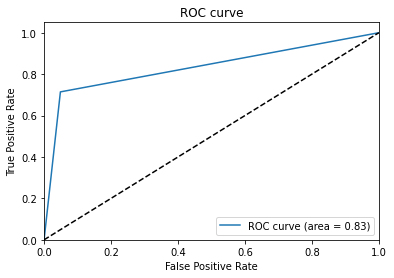

In [ ]:
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

MODEL ACCURACY

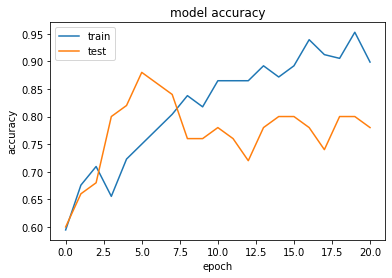

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

MODEL LOSS

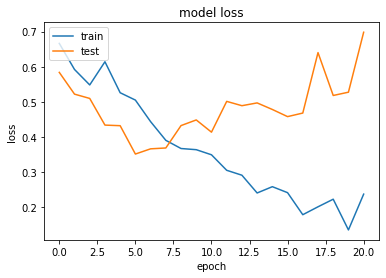

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sperimentazione Spagnolo Giapponese senza early stopping

In [ ]:
def run_experiment_without_es(model, trainX, trainy, validationX, validationy, testX, testy):
  tf.random.set_seed(42)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy)) 
  #model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions


In [ ]:
# run the experiment
with tf.device('/device:GPU:0'):
  trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
  model = create_model()
  history, predictions = run_experiment_without_es(model, trainX, trainy, validationX, validationy, testX, testy)

(148, 350, 66) (148, 1)
(55, 350, 66) (55, 1)
(148, 350, 66) (148, 2) (55, 350, 66) (55, 2) (50, 350, 66) (50, 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


2/2 [==============================] - 0s 32ms/step - loss: 0.4045 - accuracy: 0.9091


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1]


In [ ]:
from sklearn.metrics import classification_report
testy = np.argmax(testy, axis=1)
target_names = list(LANGUAGES.values())
print(classification_report(testy, predictions, target_names=target_names))

              precision    recall  f1-score   support

    Spagnolo       0.93      0.95      0.94        41
  Giapponese       0.85      0.79      0.81        14

    accuracy                           0.91        55
   macro avg       0.89      0.87      0.88        55
weighted avg       0.91      0.91      0.91        55



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

[[[ 8  6]
  [ 0 41]]

 [[41  0]
  [ 6  8]]]


Text(132.0, 0.5, 'predetti')

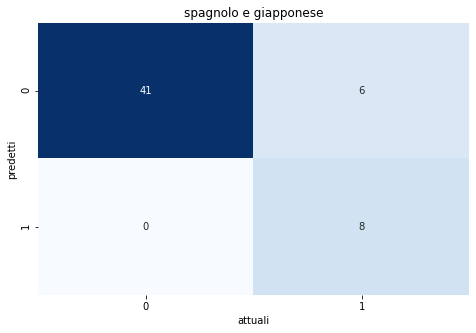

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

valori=pd.crosstab(predictions,testy)
fig=plt.figure(figsize=(17,5))
ax1=plt.subplot(121)
ax1.set_title("spagnolo e giapponese")
sns.heatmap(valori,annot=True,cmap="Blues",cbar=False)
plt.xlabel("attuali") 
plt.ylabel("predetti")

41 6 0 8
8 0 6 41


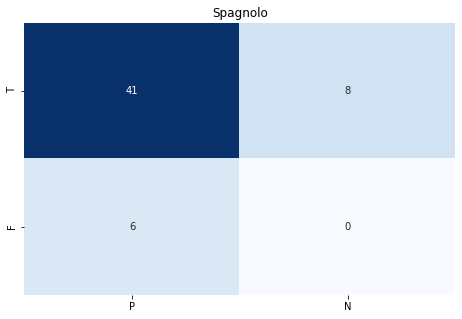

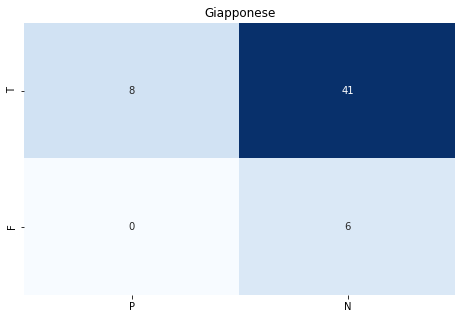

In [ ]:
for j in (list(LANGUAGES_N.keys())):
  i = LANGUAGES_N[j]
  TP= valori.iloc[i,i]
  FP= valori.iloc[i,:].sum()-TP
  FN= valori.iloc[:,i].sum()-TP
  TN= valori.sum().sum() - TP - FP - FN
  print(TP,FP,FN,TN)
  #b=[[TP,FP],[FN,TN]]
  b=[[TP,TN],[FP,FN]]
  fig=plt.figure(figsize=(17,5))
  ax1=plt.subplot(121)
  sns.heatmap(b,annot=True,cmap="Blues",cbar=False,fmt = "g")
  #plt.xlabel("POSITIVI") 
  #plt.ylabel("NEGATIVI")
  tick_marks = [0.5,1.5]
  plt.title(LANGUAGES[j])
  plt.xticks(tick_marks, ["P","N",])
  plt.yticks(tick_marks, ["T","F"])

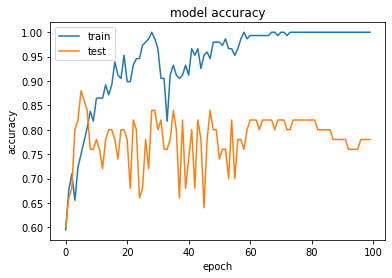

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

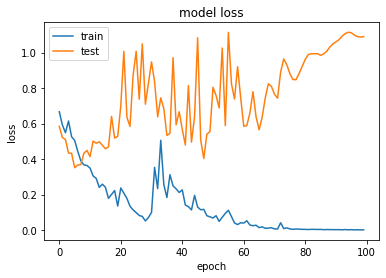

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()